In [1]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#define function that cleans the dataset

def clean_data(df):
    
    #drop columns with more than 50 empty columns
    
    df.dropna(axis=1,thresh=50, inplace=True)

    #drop the indicator name,code variables as they aren't noisy

    df.drop(["Indicator Name", "Indicator Code"], axis=1,inplace=True)

    #drop rows with more than 12 missing years
    df.dropna(axis=0,thresh=12, inplace=True)

    return df

In [3]:
#function to left join df with the income/region metadata and separate them into 2 different dfs country and region

# left join the 2 dataframes
def separate_df(data_df, metadata_df):
    
    combined_df= pd.merge(data_df,metadata_df, on='Country Code', how='left')
    
    # seperate countries and regions in 2 different dataframes
    
    country_df = combined_df[combined_df["Region"].notna()]
    region_df = combined_df[combined_df["Region"].isna()]
    
    region_df.drop(["Region", "IncomeGroup"], axis=1, inplace=True)
    
    return country_df, region_df


In [4]:

#define function to create dummies for given column and remove it from df

def create_dummies(df,col_name):
    
    #turn column into dummies
    
    enc = pd.get_dummies( df[col_name])
    
    #join dummies at the end of df
    
    df = pd.concat([df, enc], axis=1)
    
    #drop original column from df
    
    df.drop(col_name,axis=1,inplace=True)
    
    return df
    


In [5]:
#define a function to breakdown the GDP investment df into subcategories

def separate_inv(inv_df, ind, value_i, sub_ind, value_s):

#select indicator to be split
    split_1 = inv_df[inv_df[ind] == value_i]

#select sub-indicator to be split
    split_2 = split_1[split_1[sub_ind] == value_s]

#drop indicator/subindicator columns
    split_2.drop(ind,axis=1,inplace=True)
    split_2.drop(sub_ind,axis=1,inplace=True)

#drop years 2020 and onwards
    split_2.drop(split_2.iloc[:,-9:], axis=1,inplace=True)

    return split_2

In [6]:
def unpivot(df, L, cl_var_name, cl_value_name):
    """
    This function returns unpivoted dataframe. 
    L: list of the static columns name.
    var_name: new name for the new columns of unpivoted columns (first row). 
    value_name: new name for the new columns of unpivoted values (second to last rows).
    """
    
    # Check if first introduced object is a dataframe
    if not isinstance(df, pd.DataFrame):
        print("The first introduced argument should be a dataframe.")
        return None

    # Check if the second introduced object is a list
    if not isinstance(L, list):
        print("The second introduced argument should be a list.")
        return None

    # Check if the third introduced object is a string value
    if not isinstance(cl_var_name, str):
        print("The third introduced argument should be a string value.")
        return None

    # Check if the fourth introduced object is a string value
    if not isinstance(cl_var_name, str):
        print("The fourth introduced argument should be a string value.")
        return None

    # Unpivot dataframe
    unpivoted_df = df.melt(id_vars=L,
                           var_name=cl_var_name,
                           value_name=cl_value_name)
    return unpivoted_df

In [7]:
#define a function to fill in missing values in each column using kmean regressor
def fillna (df,v1,v2,v3,v4,v5,v6,v7,dv,dv2):

#select the variable to be predicted
    dependent = df[dv]

#select the other variables to be used in the regressor for prediction and fill in their missing values with respective averages
#(avg fillna applied because kmeans regressor doesn't work with variables that have missing values)
    tempavg = df[[v1,v2,v3,v4,v5,v6,v7]].fillna(df.mean())

#merge the two tables together for analysis
    reg = pd.concat([dependent,tempavg],axis=1).apply(pd.to_numeric)

#splitting the reg dataframe to incomplete table 
#contains the rows of each Nan value of the dependent variable in reg df
    incomplete = reg[reg[dv].isna()]
    
#splitting the reg dataframe to complete table 
#contains the rows of each valid value of the dependent variable in reg df
    complete = reg[~reg.index.isin(incomplete.index)]

#setting the kmeans regressor using euclidean distances
    regressor = KNeighborsRegressor(10,weights = 'distance',metric = 'euclidean')

#applying the regressor to the dataframe
    fitting = regressor.fit(complete.loc[:,[v1,v2,v3,v4,v5,v6,v7]],complete.loc[:,[dv]])
    
#predicting the values in the incomplete table 
    incomplete[dv2] = fitting.predict(incomplete.drop(columns=[dv]))

#cleaning the incomplete df and getting ready to merge back to the original dataframe
    incomplete.drop([v1,v2,v3,v4,v5,v6,v7,dv],axis=1,inplace=True)

#applying concatenate to the original df
    df = pd.concat([df,incomplete],axis=1)

#fillna of dependent and predicted columns with 0, to be able to add back to the original df
    df[[dv,dv2]] = df[[dv,dv2]].fillna(0)

#add the new values to the original column in the original df
    df[dv] = df[dv] + df[dv2] 

#drop the predicted column from the original df
    df.drop(columns=[dv2],inplace=True)

#return the original df
    return df

In [8]:

# import expenditure data from csv and clean data 

receipt_df = pd.read_csv("C:/Users/Lenovo/Documents/DSAA - BA/Programming for Data Science/Project/API_ST.INT.RCPT.CD_DS2_en_csv_v2_259854.csv", skiprows=4)

receipt_df = clean_data(receipt_df)

In [9]:
#import international inbound tourist data from csv and clean the data

tourist_df=pd.read_csv("C:/Users/Lenovo/Documents/DSAA - BA/Programming for Data Science/Project/API_ST.INT.ARVL_DS2_en_csv_v2_103871.csv", skiprows=4)

tourist_df = clean_data(tourist_df)

tourist_df.head()

,Country Name,Country Code,1995,1996,1997,1998,1999,2000,2001,2002,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,6.190000e+05,6.410000e+05,6.500000e+05,6.470000e+05,6.830000e+05,7.210000e+05,6.910000e+05,6.430000e+05,...,8.270000e+05,8.130000e+05,8.240000e+05,8.690000e+05,9.040000e+05,9.790000e+05,1.072000e+06,1.225000e+06,1.102000e+06,1.070500e+06
2,Angola,AGO,9.000000e+03,2.100000e+04,4.500000e+04,5.200000e+04,4.500000e+04,5.100000e+04,6.700000e+04,9.100000e+04,...,2.940000e+05,3.660000e+05,4.250000e+05,4.810000e+05,5.280000e+05,6.500000e+05,5.950000e+05,5.920000e+05,3.970000e+05,2.610000e+05
3,Albania,ALB,3.040000e+05,2.870000e+05,1.190000e+05,1.840000e+05,3.710000e+05,3.170000e+05,3.540000e+05,4.700000e+05,...,1.247000e+06,1.711000e+06,2.191000e+06,2.469000e+06,3.156000e+06,2.857000e+06,3.341000e+06,3.784000e+06,4.070000e+06,4.643000e+06
4,Andorra,AND,NaN,NaN,NaN,NaN,2.347000e+06,2.949000e+06,3.516000e+06,3.387000e+06,...,2.059000e+06,1.830000e+06,1.808000e+06,2.242000e+06,2.238000e+06,2.328000e+06,2.363000e+06,2.663000e+06,2.831000e+06,NaN
5,Arab World,ARB,2.115522e+07,2.192905e+07,2.384332e+07,2.623208e+07,3.010843e+07,3.391257e+07,3.478617e+07,3.904145e+07,...,7.456862e+07,7.372749e+07,8.459515e+07,7.090156e+07,7.899196e+07,7.869716e+07,8.415708e+07,7.885381e+07,7.636341e+07,8.221460e+07


In [10]:
startup_df = pd.read_csv("C:/Users/Lenovo/Documents/DSAA - BA/Programming for Data Science/Project/Start-up procedures to register a business.csv",skiprows =4)
startup_df = clean_data(startup_df)
startup_df.head()

,Country Name,Country Code,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
1,Afghanistan,AFG,NaN,4.0000,4.000000,4.000000,5.00,5.00,5.0,5.0,5.00,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
2,Angola,AGO,12.000000,12.0000,12.000000,12.000000,12.00,8.00,8.0,8.0,8.00,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
3,Albania,ALB,12.000000,12.0000,12.000000,12.000000,11.00,8.00,6.0,6.0,6.00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
5,Arab World,ARB,12.307692,11.6875,11.333333,11.333333,10.45,9.55,9.3,9.4,9.25,9.142857,8.904762,8.714286,8.590909,8.363636,7.863636,7.181818
6,United Arab Emirates,ARE,10.000000,10.0000,10.000000,10.000000,9.00,9.00,8.0,8.0,7.00,6.000000,6.000000,6.000000,6.000000,4.000000,4.000000,2.000000


In [11]:
# import country region and income information
country_info = pd.read_csv("C:/Users/Lenovo/Documents/DSAA - BA/Programming for Data Science/Project/Metadata_Country_API_ST.INT.ARVL_DS2_en_csv_v2_103871.csv", usecols=[0,1,2])
country_info.head()

,Country Code,Region,IncomeGroup
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income


In [12]:
# import GDP and investment information
investment_GDP_df = pd.read_csv("C:/Users/Lenovo/Documents/DSAA - BA/Programming for Data Science/Project/Public_Private Spending on travel and Tourism service.csv")

investment_GDP_df.dropna(axis=1,thresh=50, inplace=True)
investment_GDP_df = investment_GDP_df.rename(columns={'Country ISO3': 'Country Code'})
investment_GDP_df.drop(["Indicator Id"], axis=1,inplace=True)

investment_GDP_df.dropna(axis=0,thresh=12, inplace=True)

investment_GDP_df = investment_GDP_df.fillna(0)
investment_GDP_df.head()


,Country Code,Country Name,Indicator,Subindicator Type,1995,1996,1997,1998,1999,2000,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
0,ABW,Aruba,Government spending on travel and Tourism service,US$ in bn (Real prices),0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
1,ABW,Aruba,Government spending on travel and Tourism service,% share of total tourism expenditure,17.369100,18.511000,15.714400,14.675300,15.828500,15.914900,...,17.560300,17.651500,17.743200,17.835400,17.928100,18.021200,18.114800,18.208900,18.303500,18.398600
2,ABW,Aruba,Capital investment in Travel and Tourism,US$ in bn (Real prices),0.195498,0.229916,0.330223,0.232969,0.223276,0.153693,...,0.200177,0.204063,0.209092,0.214346,0.221743,0.227012,0.230596,0.232477,0.232387,0.233371
3,ABW,Aruba,Travel and Tourism total contribution to GDP,Percentage share of total GDP,42.500600,61.017300,63.450300,64.002100,59.835100,60.923700,...,86.595400,87.613100,88.640200,89.296400,90.174500,90.179600,90.974500,91.230700,91.013900,91.651200
4,ABW,Aruba,Travel and Tourism total contribution to GDP,US$ in bn (Real prices),0.937878,1.363260,1.528390,1.644470,1.555150,1.654920,...,2.456100,2.524320,2.597360,2.671890,2.749110,2.806970,2.860190,2.894330,2.933290,2.965680


In [13]:

GDP_pct = separate_inv(investment_GDP_df,"Indicator",'Travel and Tourism total contribution to GDP','Subindicator Type','Percentage share of total GDP')

GDP_govt = separate_inv(investment_GDP_df,"Indicator",'Government spending on travel and Tourism service','Subindicator Type',"US$ in bn (Real prices)")

GDP_govt_pct = separate_inv(investment_GDP_df,"Indicator",'Government spending on travel and Tourism service','Subindicator Type',"% share of total tourism expenditure")

GDP_cap = separate_inv(investment_GDP_df,"Indicator",'Capital investment in Travel and Tourism','Subindicator Type',"US$ in bn (Real prices)")

GDP_pct.head()

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Country Code,Country Name,1995,1996,1997,1998,1999,2000,2001,2002,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
3,ABW,Aruba,42.50060,61.01730,63.45030,64.00210,59.83510,60.92370,57.09440,57.09640,...,78.91120,71.98230,81.96960,85.27720,88.78350,88.68340,89.9234,86.51840,85.60000,86.59540
8,AGO,Angola,1.74291,2.08690,1.31310,3.35741,2.68968,1.99362,1.93643,2.76941,...,3.92187,3.27314,3.96158,4.38231,4.28051,4.24098,3.6797,3.80397,3.84565,3.87318
13,ALB,Albania,11.20760,9.17086,10.36500,9.53902,13.33060,17.30970,18.41520,21.18670,...,23.91040,22.98380,24.95270,23.41440,24.77550,24.71080,26.0856,26.16730,26.33710,26.27060
18,ARE,United Arab Emirates,4.58548,4.80991,4.67756,3.92708,4.51956,4.17632,4.12760,4.17576,...,8.27160,7.92635,7.90240,8.83063,8.56885,10.37290,11.1482,11.33290,11.23410,10.78570
23,ARG,Argentina,9.15859,9.08101,9.67127,9.72175,9.87789,9.75165,9.78442,12.33670,...,11.92890,11.20390,10.64860,10.27430,9.99388,9.55704,10.1034,10.25440,10.29390,10.18480


In [14]:
population = pd.read_csv('C:/Users/Lenovo/Documents/DSAA - BA/Programming for Data Science/Project/Population by country.csv', encoding="ISO-8859-1",skiprows=4)
population.drop(population.loc[:,'1960':'1994'],axis=1,inplace=True)
population = clean_data (population)
population.columns

Index(['Country Name', 'Country Code', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'],
      dtype='object')

In [15]:
# Using unpivot function
unpivot_pop = unpivot(population, ['Country Name', 'Country Code'], 'Year', 'Population')
unpivot_receipt = unpivot(receipt_df, ['Country Name', 'Country Code'], 'Year', 'Receipt')
unpivot_tourist = unpivot(tourist_df, ['Country Name', 'Country Code'], 'Year', 'TouristNumber')
unpivot_startup = unpivot(startup_df, ['Country Name', 'Country Code'], 'Year', 'StartupSteps')
unpivot_GDP_pct = unpivot(GDP_pct, ['Country Name', 'Country Code'], 'Year', 'GDPpct')
unpivot_GDP_govt = unpivot(GDP_govt, ['Country Name', 'Country Code'], 'Year', 'GDPgovt')
unpivot_GDP_govt_pct = unpivot(GDP_govt_pct, ['Country Name', 'Country Code'], 'Year', 'GDPgovtpct')
unpivot_GDP_cap = unpivot(GDP_cap, ['Country Name', 'Country Code'], 'Year', 'GDPcap')
dfs=[unpivot_pop,unpivot_receipt,unpivot_tourist,unpivot_startup,unpivot_GDP_pct,unpivot_GDP_govt,unpivot_GDP_govt_pct,unpivot_GDP_cap]
merged_df = reduce(lambda left,right: pd.merge(left, right, on=['Country Name', 'Country Code','Year'], how='left'), dfs)
merged_df.head()

,Country Name,Country Code,Year,Population,Receipt,TouristNumber,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
0,Aruba,ABW,1995,80324.0,554000000.0,619000.0,NaN,42.50060,0.01,17.36910,0.195498
1,Afghanistan,AFG,1995,18110657.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,1995,13945206.0,27000000.0,9000.0,NaN,1.74291,0.00,1.11433,0.290084
3,Albania,ALB,1995,3187784.0,70000000.0,304000.0,NaN,11.20760,0.00,3.85652,0.030000
4,Andorra,AND,1995,63850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
merged_country_df, merged_region_df = separate_df (merged_df, country_info)
merged_country_df.head()

,Country Name,Country Code,Year,Population,Receipt,TouristNumber,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap,Region,IncomeGroup
0,Aruba,ABW,1995,80324.0,554000000.0,619000.0,NaN,42.50060,0.01,17.36910,0.195498,Latin America & Caribbean,High income
1,Afghanistan,AFG,1995,18110657.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,Low income
2,Angola,AGO,1995,13945206.0,27000000.0,9000.0,NaN,1.74291,0.00,1.11433,0.290084,Sub-Saharan Africa,Lower middle income
3,Albania,ALB,1995,3187784.0,70000000.0,304000.0,NaN,11.20760,0.00,3.85652,0.030000,Europe & Central Asia,Upper middle income
4,Andorra,AND,1995,63850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Central Asia,High income


In [17]:
#test dummy function
country_info = create_dummies(country_info,col_name ='IncomeGroup')
country_info.head()

,Country Code,Region,High income,Low income,Lower middle income,Upper middle income
0,ABW,Latin America & Caribbean,1,0,0,0
1,AFG,South Asia,0,1,0,0
2,AGO,Sub-Saharan Africa,0,0,1,0
3,ALB,Europe & Central Asia,0,0,0,1
4,AND,Europe & Central Asia,1,0,0,0


In [18]:
#sort country data from highest

merged_country_df.sort_values("TouristNumber",inplace=True, ascending=False)


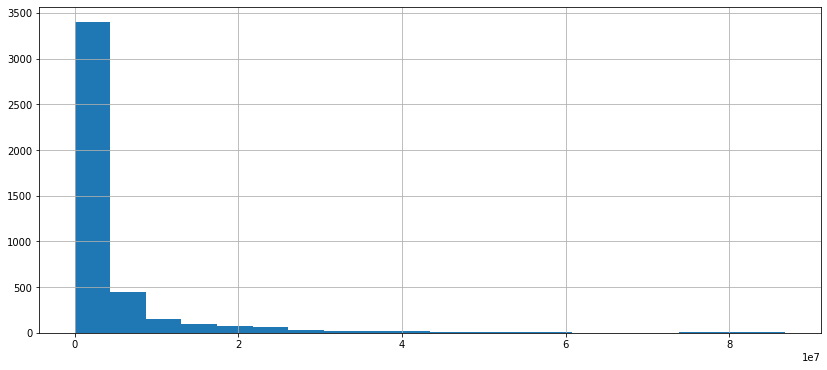

In [19]:
#plot histogram?
merged_country_df["TouristNumber"].hist(bins=20, figsize=[14,6])

In [20]:
#get all the values in the rows for Country Name
region_cols =merged_region_df['Country Name'].values

In [21]:
#seperate them according to specific words in the name
income_cols = [s for s in list(region_cols) if "income" in s]
dividend_cols =[s for s in list(region_cols) if "dividend" in s]
IDA_IBRD_cols =[s for s in list(region_cols) if ("IDA" in s or "IBRD" in s)]
not_classified_cols =[s for s in list(region_cols) if "not classified" in s]
organization_cols =[s for s in list(region_cols) if ("OECD members" in s or "Arab World" in s)]
small_states_cols =[s for s in list(region_cols) if "small states" in s]
other_cols =[s for s in list(region_cols) if ("Fragile and conflict affected situations" in s or "Heavily indebted poor countries (HIPC)" in s or "Least developed countries: UN classification" in s or "World" in s)]


In [22]:
#assign a classification to each list of names
def cond(x):
    if x in dividend_cols:
        return "Dividend" 
    elif x in IDA_IBRD_cols:
        return "IDA & IBRD" 
    elif x in income_cols:
        return "Income"
    elif x in not_classified_cols:
        return "Not Classified"
    elif x in organization_cols:
        return "Organization"
    elif x in small_states_cols:
        return "Small States"
    elif x in other_cols:
        return "Other"
    else:
        return "Group Region"
    return x

#assign classfication for every name in Country Name column
cat_col = [cond(x) for x in merged_region_df['Country Name']] 

#position we want to insert in df (3rd column)
idx = 2
#insert in existing df
merged_region_df.insert(loc=idx, column='Location Group', value=cat_col)
#show first 10 values to test it worked
merged_region_df.head(10)

,Country Name,Country Code,Location Group,Year,Population,Receipt,TouristNumber,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
5,Arab World,ARB,Organization,1995,2.531073e+08,1.394575e+10,2.115522e+07,NaN,NaN,NaN,NaN,NaN
34,Central Europe and the Baltics,CEB,Group Region,1995,1.098642e+08,1.779400e+10,3.922400e+07,NaN,NaN,NaN,NaN,NaN
47,Caribbean small states,CSS,Small States,1995,6.281190e+06,4.291000e+09,4.485000e+06,NaN,NaN,NaN,NaN,NaN
59,East Asia & Pacific (excluding high income),EAP,Income,1995,1.717912e+09,3.126292e+10,4.357427e+07,NaN,NaN,NaN,NaN,NaN
60,Early-demographic dividend,EAR,Dividend,1995,2.250116e+09,4.544011e+10,7.002636e+07,NaN,NaN,NaN,NaN,NaN
61,East Asia & Pacific,EAS,Group Region,1995,1.942431e+09,8.069070e+10,7.763398e+07,NaN,NaN,NaN,NaN,NaN
62,Europe & Central Asia (excluding high income),ECA,Income,1995,3.912938e+08,1.177035e+10,3.227846e+07,NaN,NaN,NaN,NaN,NaN
63,Europe & Central Asia,ECS,Group Region,1995,8.562129e+08,2.405635e+11,2.955132e+08,NaN,NaN,NaN,NaN,NaN
66,Euro area,EMU,Group Region,1995,3.171814e+08,1.646001e+11,1.968470e+08,NaN,NaN,NaN,NaN,NaN
71,European Union,EUU,Group Region,1995,4.842224e+08,2.157031e+11,2.587999e+08,NaN,NaN,NaN,NaN,NaN


In [23]:
merged_country_df.isna().sum()

Country Name        0
Country Code        0
Year                0
Population         10
Receipt           981
TouristNumber     825
StartupSteps     2555
GDPpct           1008
GDPgovt          1008
GDPgovtpct       1008
GDPcap           1008
Region              0
IncomeGroup         0
dtype: int64

In [24]:
#Tourist number
merged_country_df = fillna(merged_country_df,"Population",'Receipt',"StartupSteps","GDPpct","GDPgovt","GDPgovtpct","GDPcap","TouristNumber","TouristNumber1")
#Receipt
merged_country_df = fillna(merged_country_df,"Population","TouristNumber","StartupSteps","GDPpct","GDPgovt","GDPgovtpct","GDPcap","Receipt","Receipt1")
#GDPpct
merged_country_df = fillna(merged_country_df,"Population","TouristNumber","Receipt","StartupSteps","GDPgovt","GDPgovtpct","GDPcap","GDPpct","GDPpct1")
#GDPgovt
merged_country_df = fillna(merged_country_df,"Population","TouristNumber","Receipt","StartupSteps","GDPpct","GDPgovtpct","GDPcap","GDPgovt","GDPgovt1")
#GDPgovtpct
merged_country_df = fillna(merged_country_df,"Population","TouristNumber","Receipt","StartupSteps","GDPgovt","GDPpct","GDPcap","GDPgovtpct","GDPgovtpct1")
#startupsteps
merged_country_df = fillna(merged_country_df,"Population","TouristNumber","Receipt","GDPpct","GDPgovt","GDPgovtpct","GDPcap","StartupSteps","StartupSteps1")
#GDPcap
merged_country_df = fillna(merged_country_df,"Population","TouristNumber","Receipt","StartupSteps","GDPgovt","GDPgovtpct","GDPpct","GDPcap","GDPcap1")
#population
merged_country_df = fillna(merged_country_df,"GDPcap","TouristNumber","Receipt","StartupSteps","GDPgovt","GDPgovtpct","GDPpct","Population","Population1")

merged_country_df

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

,Country Name,Country Code,Year,Population,Receipt,TouristNumber,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap,Region,IncomeGroup
0,Aruba,ABW,1995,80324.0,5.540000e+08,6.190000e+05,8.272939,42.500600,0.010000,17.369100,0.195498,Latin America & Caribbean,High income
1,Afghanistan,AFG,1995,18110657.0,1.803947e+08,9.730972e+05,7.744281,6.826604,0.004064,1.590417,0.111475,South Asia,Low income
2,Angola,AGO,1995,13945206.0,2.700000e+07,9.000000e+03,9.091266,1.742910,0.000000,1.114330,0.290084,Sub-Saharan Africa,Lower middle income
3,Albania,ALB,1995,3187784.0,7.000000e+07,3.040000e+05,9.961231,11.207600,0.000000,3.856520,0.030000,Europe & Central Asia,Upper middle income
4,Andorra,AND,1995,63850.0,1.733486e+09,1.380041e+06,7.425056,63.494488,0.026022,15.687454,0.253642,Europe & Central Asia,High income
6,United Arab Emirates,ARE,1995,2415090.0,6.320000e+08,2.315000e+06,8.766111,4.585480,0.134578,2.300000,0.551302,Middle East & North Africa,High income
7,Argentina,ARG,1995,34828170.0,2.550000e+09,2.289000e+06,7.073704,9.158590,0.166556,2.539100,2.038170,Latin America & Caribbean,Upper middle income
8,Armenia,ARM,1995,3217348.0,1.400000e+07,1.200000e+04,9.967244,3.513150,0.000000,2.000000,0.000000,Europe & Central Asia,Upper middle income
9,American Samoa,ASM,1995,53161.0,3.635206e+06,3.400000e+04,5.584199,16.067580,0.000000,2.437143,0.000794,East Asia & Pacific,Upper middle income
10,Antigua and Barbuda,ATG,1995,68670.0,2.470000e+08,2.200000e+05,9.270697,73.995900,0.010000,31.575100,0.080000,Latin America & Caribbean,High income


In [25]:
merged_country_df.isna().sum()

Country Name     0
Country Code     0
Year             0
Population       0
Receipt          0
TouristNumber    0
StartupSteps     0
GDPpct           0
GDPgovt          0
GDPgovtpct       0
GDPcap           0
Region           0
IncomeGroup      0
dtype: int64

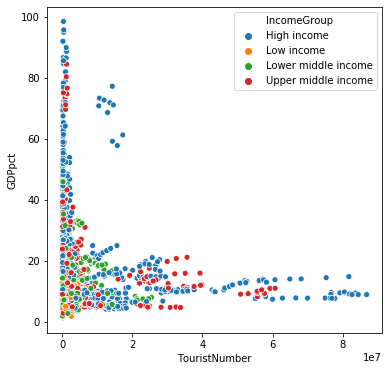

In [83]:
merged_country_df['Year'] = merged_country_df['Year'].astype(float)

yrs  = merged_country_df[merged_country_df['Year'] > 2007]

fig = plt.figure(figsize=(6,6))
ax = sb.scatterplot(x="TouristNumber", y="GDPpct", data=yrs,hue="IncomeGroup")

plt.show()

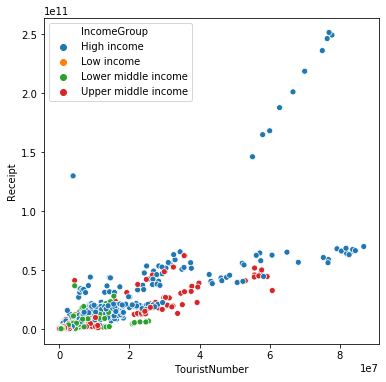

In [71]:
fig = plt.figure(figsize=(6,6))
ax = sb.scatterplot(x="TouristNumber", y="Receipt", data=yrs,hue="IncomeGroup")

plt.show()

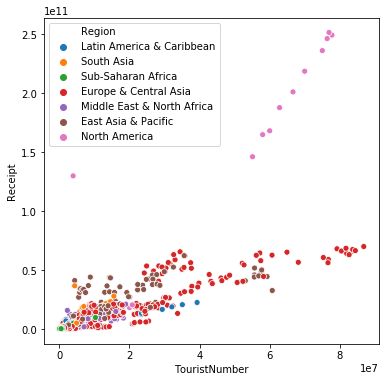

In [72]:
fig = plt.figure(figsize=(6,6))
ax = sb.scatterplot(x="TouristNumber", y="Receipt", data=yrs,hue="Region")

plt.show()

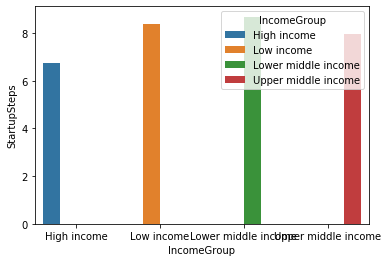

In [79]:

ax = sb.barplot(x="IncomeGroup", y="StartupSteps", data=yrs,ci=None,hue="IncomeGroup")

plt.show()

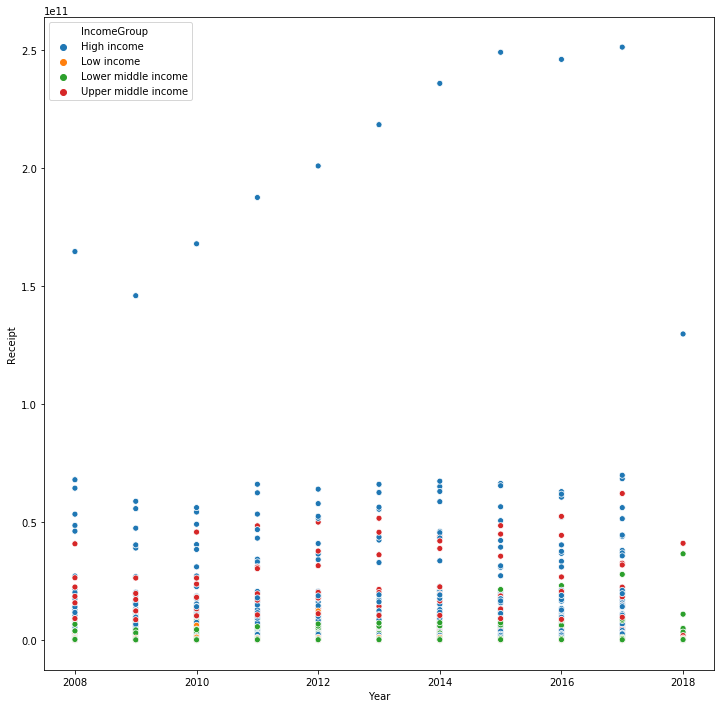

In [80]:
fig = plt.figure(figsize=(12,12))

ax = sb.scatterplot(x="Year", y="Receipt", data=yrs,ci=None,hue="IncomeGroup")

plt.show()

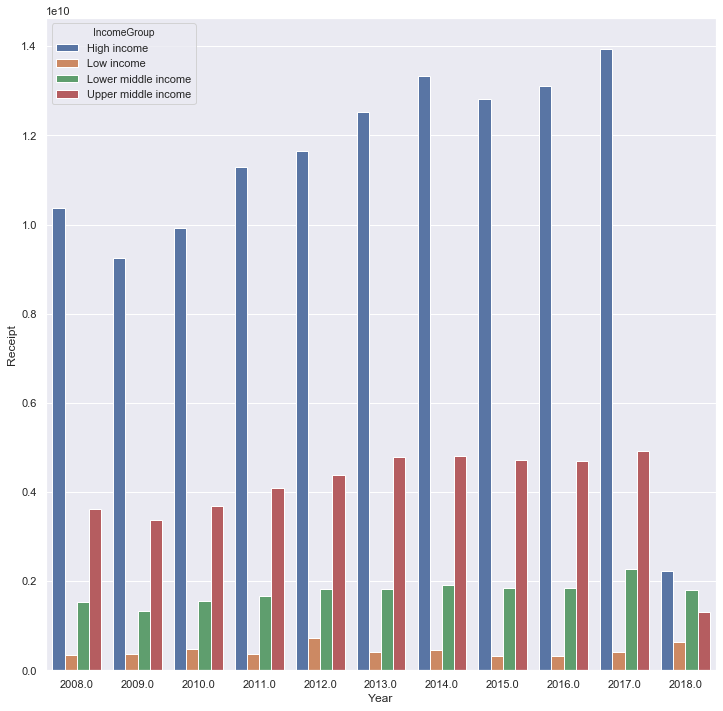

In [87]:
fig = plt.figure(figsize=(12,12))
ax = sb.barplot(x="Year", y="Receipt", data=yrs,ci=None,hue="IncomeGroup")